# Anomaly detection

Anomaly detection is a machine learning task that consists in spotting so-called outliers.

“An outlier is an observation in a data set which appears to be inconsistent with the remainder of that set of data.”
Johnson 1992

“An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.”
  Outlier/Anomaly
Hawkins 1980

### Types of anomaly detection setups

- Supervised AD
    - Labels available for both normal data and anomalies
    - Similar to rare class mining / imbalanced classification
- Semi-supervised AD (Novelty Detection)
    - Only normal data available to train
    - The algorithm learns on normal data only
- Unsupervised AD (Outlier Detection)
    - no labels, training set = normal + abnormal data
    - Assumption: anomalies are very rare

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Let's first get familiar with different unsupervised anomaly detection approaches and algorithms. In order to visualise the output of the different algorithms we consider a toy data set consisting in a two-dimensional Gaussian mixture.

### Generating the data set

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_features=2, centers=3, n_samples=500,
                  random_state=42)

In [3]:
X.shape

(500, 2)

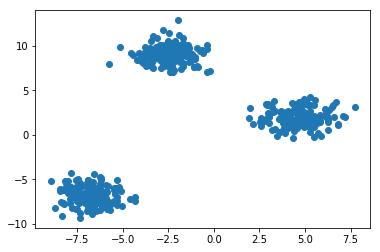

In [4]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.show()

## Anomaly detection with density estimation

In [5]:
from sklearn.neighbors.kde import KernelDensity

# Estimate density with a Gaussian kernel density estimator
kde = KernelDensity(kernel='gaussian')
kde = kde.fit(X)
kde

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [6]:
kde_X = kde.score_samples(X)
print(kde_X.shape)  # contains the log-likelihood of the data. The smaller it is the rarer is the sample

(500,)


In [7]:
from scipy.stats.mstats import mquantiles
alpha_set = 0.95
tau_kde = mquantiles(kde_X, 1. - alpha_set)

In [8]:
n_samples, n_features = X.shape
X_range = np.zeros((n_features, 2))
X_range[:, 0] = np.min(X, axis=0) - 1.
X_range[:, 1] = np.max(X, axis=0) + 1.

h = 0.1  # step size of the mesh
x_min, x_max = X_range[0]
y_min, y_max = X_range[1]
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]

No handles with labels found to put in legend.


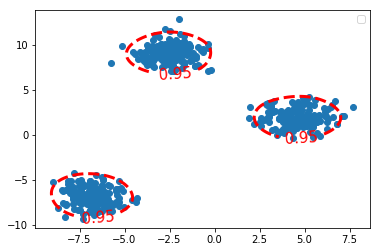

In [9]:
Z_kde = kde.score_samples(grid)
Z_kde = Z_kde.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_kde, levels=tau_kde, colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={tau_kde[0]: str(alpha_set)})
plt.scatter(X[:, 0], X[:, 1])
plt.legend()
plt.show()

## now with One-Class SVM

The problem of density based estimation is that they tend to become inefficient when the dimensionality of the data increase. It's the so-called curse of dimensionality that affects particularly density estimation algorithms. The one-class SVM algorithm can be used in such cases.

In [10]:
from sklearn.svm import OneClassSVM

In [11]:
nu = 0.05  # theory says it should be an upper bound of the fraction of outliers
ocsvm = OneClassSVM(kernel='rbf', gamma=0.05, nu=nu)
ocsvm.fit(X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.05, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [12]:
X_outliers = X[ocsvm.predict(X) == -1]

No handles with labels found to put in legend.


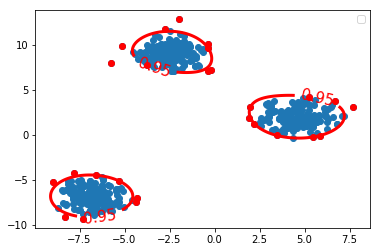

In [13]:
Z_ocsvm = ocsvm.decision_function(grid)
Z_ocsvm = Z_ocsvm.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_ocsvm, levels=[0], colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15, fmt={0: str(alpha_set)})
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], color='red')
plt.legend()
plt.show()

### Support vectors - Outliers

The so-called support vectors of the one-class SVM form the outliers

In [14]:
X_SV = X[ocsvm.support_]
n_SV = len(X_SV)
n_outliers = len(X_outliers)

print('{0:.2f} <= {1:.2f} <= {2:.2f}?'.format(1./n_samples*n_outliers, nu, 1./n_samples*n_SV))

0.05 <= 0.05 <= 0.06?


Only the support vectors are involved in the decision function of the One-Class SVM.

1. Plot the level sets of the One-Class SVM decision function as we did for the true density.
2. Emphasize the Support vectors.

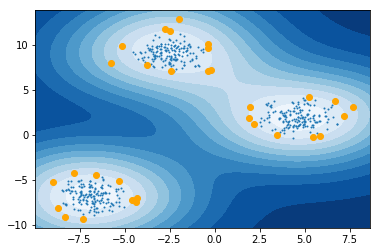

In [15]:
plt.figure()
plt.contourf(xx, yy, Z_ocsvm, 10, cmap=plt.cm.Blues_r)
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.scatter(X_SV[:, 0], X_SV[:, 1], color='orange')
plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      **Change** the `gamma` parameter and see it's influence on the smoothness of the decision function.
      </li>
    </ul>
</div>

In [16]:
# %load solutions/22_A-anomaly_ocsvm_gamma.py

## Isolation Forest

Isolation Forest is an anomaly detection algorithm based on trees. The algorithm builds a number of random trees and the rationale is that if a sample is isolated it should alone in a leaf after very few random splits. Isolation Forest builds a score of abnormality based the depth of the tree at which samples end up.

In [17]:
from sklearn.ensemble import IsolationForest

In [18]:
iforest = IsolationForest(n_estimators=300, contamination=0.10)
iforest = iforest.fit(X)

No handles with labels found to put in legend.


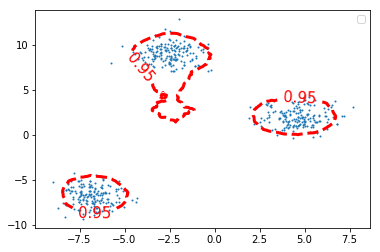

In [19]:
Z_iforest = iforest.decision_function(grid)
Z_iforest = Z_iforest.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx, yy, Z_iforest,
                  levels=[iforest.threshold_],
                  colors='red', linewidths=3)
plt.clabel(c_0, inline=1, fontsize=15,
           fmt={iforest.threshold_: str(alpha_set)})
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.legend()
plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      Illustrate graphically the influence of the number of trees on the smoothness of the decision function?
      </li>
    </ul>
</div>

In [20]:
# %load solutions/22_B-anomaly_iforest_n_trees.py

# Illustration on Digits data set


We will now apply the IsolationForest algorithm to spot digits written in an unconventional way.

In [21]:
from sklearn.datasets import load_digits
digits = load_digits()

The digits data set consists in images (8 x 8) of digits.

In [22]:
images = digits.images
labels = digits.target
images.shape

(1797, 8, 8)

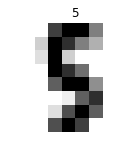

In [23]:
i = 102

plt.figure(figsize=(2, 2))
plt.title('{0}'.format(labels[i]))
plt.axis('off')
plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

To use the images as a training set we need to flatten the images.

In [24]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

In [25]:
data.shape

(1797, 64)

In [26]:
X = data
y = digits.target

In [27]:
X.shape

(1797, 64)

Let's focus on digit 5.

In [28]:
X_5 = X[y == 5]

In [29]:
X_5.shape

(182, 64)

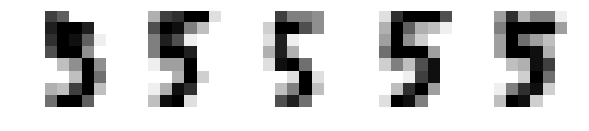

In [30]:
fig, axes = plt.subplots(1, 5, figsize=(10, 4))
for ax, x in zip(axes, X_5[:5]):
    img = x.reshape(8, 8)
    ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')

1. Let's use IsolationForest to find the top 5% most abnormal images.
2. Let's plot them !

In [31]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(contamination=0.05)
iforest = iforest.fit(X_5)

Compute the level of "abnormality" with `iforest.decision_function`. The lower, the more abnormal.

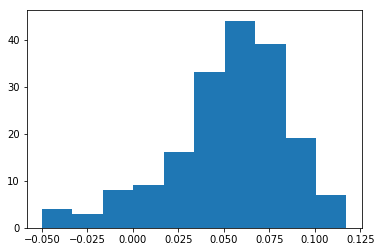

In [32]:
iforest_X = iforest.decision_function(X_5)
plt.hist(iforest_X);

Let's plot the strongest inliers

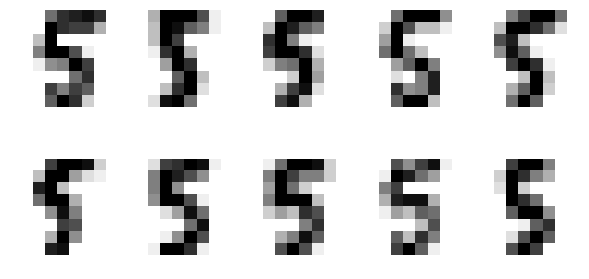

In [33]:
X_strong_inliers = X_5[np.argsort(iforest_X)[-10:]]

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in zip(range(len(X_strong_inliers)), axes.ravel()):
    ax.imshow(X_strong_inliers[i].reshape((8, 8)),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')

Let's plot the strongest outliers

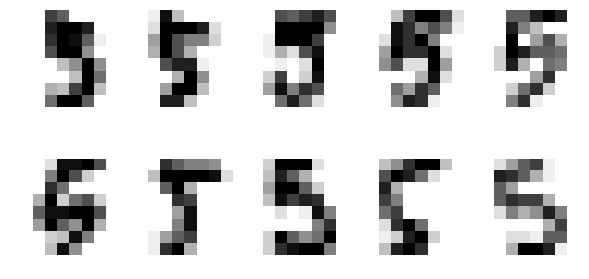

In [34]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

X_outliers = X_5[iforest.predict(X_5) == -1]

for i, ax in zip(range(len(X_outliers)), axes.ravel()):
    ax.imshow(X_outliers[i].reshape((8, 8)),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax.axis('off')

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      Rerun the same analysis with all the other digits
      </li>
    </ul>
</div>

In [ ]:
# %load solutions/22_C-anomaly_digits.py